<a href="https://colab.research.google.com/github/chanhyeong00/machine_learning_study/blob/main/%EA%B0%9C%EB%B0%9C%EC%9E%90%EB%A5%BC%EC%9C%84%ED%95%9C%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EB%94%A5%EB%9F%AC%EB%8B%9D/part1.%20%EB%AA%A8%EB%8D%B8%EA%B5%AC%EC%B6%95/11.%20%EC%8B%9C%ED%80%80%EC%8A%A4%20%EB%AA%A8%EB%8D%B8%EC%9D%84%20%EC%9C%84%ED%95%9C%20%ED%95%A9%EC%84%B1%EA%B3%B1%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%EA%B3%BC%20%EC%88%9C%ED%99%98%20%EC%8B%A0%EA%B2%BD%EB%A7%9D/11.%20%EC%8B%9C%ED%80%80%EC%8A%A4%20%EB%AA%A8%EB%8D%B8%EC%9D%84%20%EC%9C%84%ED%95%9C%20%ED%95%A9%EC%84%B1%EA%B3%B1%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%EA%B3%BC%20%EC%88%9C%ED%99%98%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%20ipynb%EC%9D%98%20%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 11.1. 시퀀스 데이터를 위한 합성곱

이미지 위를 지나가며 특징을 추출하는 2D 필터를 3장에서 보았다. 신경망은 훈련을 통해 픽셀을 레이블에 매핑할 때 효과적인 필터 값을 학습한다. 이 과정을 거치며 이지에서 특징 추출

동일한 기법을 시계열 데이터에도 적용 가능하지만 하나 수정이 필요하다. 2차원이 아닌 1차원에서 수행하는 것이다.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의로 정한 패턴이므로 바꿔도 좋습니다"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """기간마다 동일한 패턴을 반복합니다"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# 시계열을 만듭니다.
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# 잡음을 추가합니다.
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

#### 11.1.1. 1D 합성곱 신경망 만들기

합성곱을 만들기 전에 이전 장에서 사용했던 윈도 데이터셋 제너레이터를 수정해야 한다.

합성곱 층을 사용하려면 샘플의 벡터 차원을 먼저 지정해야 하기 때문이다. 윈도 데이터셋은 샘플 차원이 하나였지만 명시적으로 정의하지 않았다.

이를 위해 다음처럼 tf.expand_dims을 추가해 차원 정의

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # 데이터셋 원소에 매개변수로 전달된 함수를 적용하고 그 결과를 1차원 배열로 합친다
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1) # 배치 크기를 2로 지정하겠다.
    return dataset

데이터셋 준비되었으니 밀집층 전에 합성곱 층을 추가할 수 있다.

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                           strides=1, padding='causal',
                           activation='relu',
                           input_shape=[None,1]),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.5) # 책 그대로 썼음
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 2s 14ms/step - loss: 430.7080
Epoch 2/100
31/31 [==============================] - 1s 11ms/step - loss: 103.6266
Epoch 3/100
31/31 [==============================] - 1s 11ms/step - loss: 85.7530
Epoch 4/100
31/31 [==============================] - 1s 10ms/step - loss: 77.3243
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 72.4964
Epoch 6/100
31/31 [==============================] - 1s 8ms/step - loss: 70.4977
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 69.2809
Epoch 8/100
31/31 [==============================] - 1s 10ms/step - loss: 68.8681
Epoch 9/100
31/31 [==============================] - 1s 11ms/step - loss: 68.3273
Epoch 10/100
31/31 [==============================] - 0s 8ms/step - loss: 67.5497
Epoch 11/100
31/31 [==============================] - 0s 6ms/step - loss: 67.1968
Epoch 12/100
31/31 [==============================] - 0s 8ms/step - loss: 66.6930
Epoch 13/100
31/

Conv1D 층 매개변수
- filters: 학습할 필터 개수, 필터의 가중치 값은 랜덤하게 생성되고 학습하며 데이터 맞게 조정된다.
- kernel_size: 필터 크기.
- strides: 필터가 입력 위를 지나갈 때 수행할 **스텝 크기**, 일반적으로 1이다.
- padding: 가장자리 데이터 어떻게 처리할지 결정한다. 3X1 필터 사용하면 첫 번쨰와 마지막 값이 단 한 번만 합성곱에 참여.
**시퀀스 데이터의 경우 보통 causal을 사용한다.** 이때는 현재와 과거의 타임스텝만 사용한다. 따라서 3X1 필터의 경우 현재 타임스텝과 이전 두개의 타임스텝의 값을 사용.(그냥 필터 이동한다 생각하면 된다)

***

모델 예측을 위해 입력 층의 크기가 바뀌었기 때문에 예측 코드를 조금 수정해야 한다.

이전 윈도를 고려해 값을 하나씩 예측하는 대신 시계열을 데이터셋으로 올바르게 변환했다면 전체 시계열에 대해 한 번에 예측을 수행할 수 있다.

이를 조금 쉽게 만들기 위해 특정 윈도 크기와 모델이 주어졌을 때 전체 시계열을 예측하는 헬퍼함수 만들어보겠다.

In [ ]:
def model_forecast(model, series, window_szie):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
print(series[:5])
print(series[..., np.newaxis][:5]) # 데이터셋 구조로 만들기 위해 값마다 차원 늘림
print(series[:][np.newaxis][:5]) # 전체 값을 차원 늘림

[32.48357  29.395714 33.40659  37.858486 29.14184 ]
[[32.48357 ]
 [29.395714]
 [33.40659 ]
 [37.858486]
 [29.14184 ]]
[[ 32.48357   29.395714  33.40659  ... 148.681    145.67987  160.70773 ]]


https://yeko90.tistory.com/entry/%EB%84%98%ED%8C%8C%EC%9D%B4-%EA%B8%B0%EC%B4%88-%EC%B0%A8%EC%9B%90-%EB%B3%80%EA%B2%BD%EC%B6%95%EC%86%8C%EB%A7%8C%EB%93%A4%EA%B8%B0

newaixs 참고하기 좋음

모델을 사용해 시계열 예측하려면 Conv1D 층을 위해 새로운 축을 추가한 시계열을 전달하면 된다.

In [ ]:
forecast = model_forecast(model, series[..., np.newaxis], window_size) # (?, 1) 로 만들기 위해 차원 추가, ...은 : 과 같은 의미

46/46 [==============================] - 0s 5ms/step


In [ ]:
print(forecast[split_time - window_size:-1, -1, 0]) # 모든 데이터중 일부를 고르고 마지막 행의 첫번쨰

[103.860435 105.689316 107.83124  106.620636 103.21562  103.512024
 104.190125 106.6652   106.6199   107.79169  105.08482  106.75891
 105.4263   109.97127  106.139465 109.1411   106.19099  105.552795
 102.3579   101.81147  103.84601  105.57057  104.73561  104.22128
 107.89109  111.46653  111.443825 108.02827  105.76212  106.364914
 104.17956  103.76543  100.00726  102.89102  104.82919  106.068474
 108.65288  105.03483  103.08267  101.96138  106.07602  111.16221
 109.28604  109.75133  107.11153  107.29227  107.61032  108.78092
 105.64586  107.68231  109.540054 109.77814  108.414246 107.4927
 108.739265 106.99434  105.17038  105.14905  108.4518   110.197754
 109.17578  109.07959  102.67089  106.38258  102.088684 105.886375
 102.53721  103.00242  106.49785  107.187386 109.69234  108.01326
 109.63345  109.231636 106.753555 108.470215 107.445526 106.26753
 104.669876 108.98268  112.440605 111.87566  109.05504  107.47371
 112.27458  113.03227  113.854485 112.760086 112.35378  111.02338
 109.

분할 위치를 기준으로 검증 세트에 대한 예측을 따로 분리해보겠다.

In [ ]:
results = forecast[split_time - window_size:-1,-1,0]

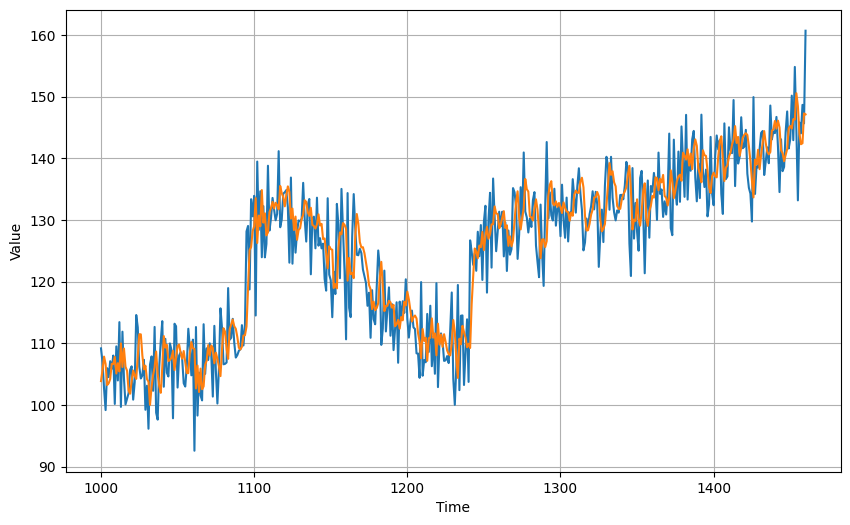

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7038603

이전 장보다 괜찮다?..

우선 이 데이터는 잡음을 가지고 있기 때문에 실행할 때마다 값이 달라진다. 10장의 코드와 이 코드를 별도로 실행하면 랜덤한 변동이 데이터와 MAE에 영향을 미칠 것이기 떄문.

합성곱을 사용할 떄는 항상 다음과 같은 질문이 따른다.

필터가 128개인 이유가 있나여? 필터의 크기는 왜 3X1 인가요?

이는 이전에 했던 것처럼 케라스튜너를 사용해 실험할 수 있다.

#### 11.1.2. Conv1D 하이퍼파라미터 튜닝하기

생각보다 MAE가 크게 영향을 받지 않았다. 이 이유는 하이퍼파라미터 떄문일 수도 있다.

이번 예제에서는 다른 매개변수는 고정하고 필터 개수, 커널 크기, 스트라이드 크기를 테스트 해보겠따.

In [ ]:
def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(
      filters=hp.Int('units', min_value=128, max_value=256, step=64),
      kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
      strides = hp.Int('strides', min_value=1, max_value=3, step=1),
      padding='causal', activation='relu', input_shape=[None, 1]
  ))

  model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  sgd = tf.keras.optimizers.SGD(momentum=0.5, learning_rate=1e-5)
  model.compile(loss='mse', optimizer=sgd)
  return model

조합의 개수가 많기 때문에 실행하는 데 시간이 좀 걸린다.

하이퍼파라미터를 탐색해보겠다.

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
from keras_tuner.tuners import RandomSearch

In [ ]:
tuner = RandomSearch(build_model, objective='loss',
                     max_trials=500, executions_per_trial=3,
                     directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()
tuner.search(dataset, epochs=100, verbose=2)

Trial 25 Complete [00h 01m 42s]
loss: 62.32232793172201

Best loss So Far: 59.680739084879555
Total elapsed time: 00h 44m 41s

Search: Running Trial #26

Value             |Best Value So Far |Hyperparameter
192               |192               |units
3                 |9                 |kernels
1                 |1                 |strides

Epoch 1/100
31/31 - 1s - loss: 374.9189 - 1s/epoch - 40ms/step
Epoch 2/100
31/31 - 0s - loss: 93.4190 - 302ms/epoch - 10ms/step
Epoch 3/100
31/31 - 0s - loss: 74.5126 - 296ms/epoch - 10ms/step
Epoch 4/100
31/31 - 0s - loss: 67.6623 - 288ms/epoch - 9ms/step
Epoch 5/100
31/31 - 0s - loss: 66.4221 - 251ms/epoch - 8ms/step
Epoch 6/100
31/31 - 0s - loss: 64.8260 - 269ms/epoch - 9ms/step
Epoch 7/100
31/31 - 0s - loss: 64.9297 - 247ms/epoch - 8ms/step
Epoch 8/100
31/31 - 0s - loss: 64.4079 - 295ms/epoch - 10ms/step
Epoch 9/100
31/31 - 0s - loss: 64.6055 - 306ms/epoch - 10ms/step
Epoch 10/100
31/31 - 0s - loss: 63.6736 - 336ms/epoch - 11ms/step
Epoch 11/10

In [ ]:
tuner.results_summary()

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
forecast = model_forecast(best_model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

MAE 결과는 4.6이다. 합성곱층을 사용하지 않았을 때 얻은 것보다 증가했을 것이다.

CNN 하이퍼 파라미터를 더 튜닝하면 더 좋은 성능을 얻을 수 있다

***
합성곱 외에도 LSTM을 포함해 RNN으로 자연어 처리를 다룬 장에서 살펴본 기술은 시퀀스 데이터를 다룰 때 유용할 수 있다.

**RNN은 문맥을 유지하도록 고안되었고, 이전 스텝의 값이 다음 스텝의 값에 영향을 미칠 수 있다.**

***
***

### 11.2. NASA 날씨 데이터 사용하기

시계열 날씨 데이터에 대한 훌륭한 자료는 NASA의 고다드 우주 연구소(GISS)에서 공개한 표면 온도 분석 자료이다.

In [ ]:
!wget https://storage.googleapis.com/learning-datasets/station.csv

https://data.giss.nasa.gov/gistemp/
자료

csv 파일은 줄 단위로 읽는다. 종종 한 줄은 하나의 데이터 포인트를 나타낸다.

이 파일은 한 줄에 12개의 데이터 포인터가 있으므로 이를 고려하며 데이터를 읽어야 한다.

#### 11.2.1. 파이썬으로 GISS 데이터 읽기

GISS 데이터를 읽는 코드는 다음과 같다.

In [ ]:
def get_station_data():
  data_file = 'station.csv'
  f = open(data_file)
  data = f.read()
  f.close()

  lines = data.split('\n')
  header = lines[0].split(',')
  lines = lines[1:]
  temperatures = []
  for line in lines:
    if line:
      linedata = line.split(',') # 하나의 변수에 저장하면 리스트로 저장됨
      linedata = linedata[1:13] # 첫번째는 년도, 그 뒤는 다른값,(월-일 날씨 데이터)
      for item in linedata:
        if item:
          temperatures.append(float(item))
  series = np.asarray(temperatures) # 카피가 안 되는 배열
  time = np.arange(len(temperatures), dtype='float32')
  return time, series

- 지정한 경로에서 파일을 열고 전체 데이터를 한 줄로 읽는다. 그리고 줄바꿈 문자로 행을 구분한다.

- 첫 번째 줄은 건너뛰고(헤더) 각 줄을 순회하면서 콤마(,)로 줄을 구분해 linedata 리스트에 추가한다.
- 문자열로 저장되어 있으므로 실수로 변환해 temperatures 리스트에 추가한다.

- time 배열은 np.arange 함수로 만들었기 때문에 첫 번째 원소가 0, 두 번쨰 원소가 1이 된다.
- 따라서 이 함수는 0에서부터 데이터 포인트 개수 -1까지 스텝을 나타내는 time과 이 타임스텝의 데이터 series를 반환한다.

In [ ]:
data_file = 'station.csv'
f2 = open(data_file)
data2 = f2.read()
f2.close()
print(data2)

**시계열 데이터 정규화 하기 위해 다음 코드 실행**

In [ ]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0) # 표준편차로 나눠줌
series /= std

이전처럼 훈련 세트, 검증 세트로 나눈다.

분할 위치는 데이터 크기에 따라 선택하면 된다.

이 데이터는 840개이므로 792에서 나누겠다.(검증을 위해 4년치 데이터를 보관한다.)

In [ ]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

데이터가 넘파이 배열이기 때문에 이전 코드를 사용 가능

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # 데이터셋 원소에 매개변수로 전달된 함수를 적용하고 그 결과를 1차원 배열로 합친다
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1) # 배치 크기를 2로 지정하겠다.
    return dataset

In [ ]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size,
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size,
                           batch_size, shuffle_buffer_size)

### 11.3. RNN으로 시퀀스 모델링하기

RNN을 사용한 간단한 모델로 시작해보겠다

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True,
                              input_shape=[None,1]),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1)
])

RNN은 지금까지 본 타임 스텝의 상태를 유지하면서 스퀀스의 타임 스텝을 처리하는 내부 순환 루프를 가지고 있다.

SimpleRNN에서는 현재 스텝의 출력이 다음 타임 스텝에 입력으로 전달된다.

하이퍼 파라미터는 간단하게 이전 설정 사용

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=100, verbose=1,
                    validation_data=valid_dataset)

In [ ]:
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series) # 데이터셋 변환
    ds = ds.window(window_size, shift=1, drop_remainder=True) # 1 칸씩 이동하며 찍음
    # 원래 같은 경우 5 -> 4 -> 3 -> 처럼 iter 형식으로 받을 수 있었는데, flat_map을 사용하면 [5, 4, 3, 2, 1]로 바로 받을 수 있다,
    ds = ds.flat_map(lambda w: w.batch(window_size)) # 데이터셋 원소에 매개변수로 전달된 함수를 적용하고 그 결과를 1차원 배열로 합친다
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:,0]
# 사이즈 맞추기 위해 끝에서 자름(time_valid.shape =(48, ) 이고, series[split_time-window_size:].shape=(49,) 이다.

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

결과가 매우 좋다. 간격이 좀 벌어진 부분도 있지만 전체적으로 나쁘지 않다.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])

에폭을 늘리면 일정 에폭에서부터 손실이 크게 줄지 않고 늘어나는 경우도 생긴다.

#### 11.3.1. 대용량 데이터셋 사용하기

KNMI Climate Explorer(https://oreil.ly/J8CP0) 는 전 세계 여러 지역의 상세한 날씨 데이터를 제공한다.



여기선 1772년부터 2020년까지 영국 중심부의 일일 온도로 구성된 데이터셋(https://oreil.ly/OCqrj)를 다운로드해 사용한다.

이 데이터는 GISS(바로 이전에 쓴 데이터) 데이터와 구조가 다르다.

 날짜는 문자열이고, 여러개의 공백 뒤에 온도가 기록되어있다.

헤더 제외하고 공백 삭제하여 데이터 준비

In [ ]:
!wget https://storage.googleapis.com/learning-datasets/tdaily_cet.dat.txt

In [ ]:
def get_tdaily_data():
  data_file = 'tdaily_cet.dat.txt'
  f = open(data_file)
  data = f.read()
  f.close()

  lines = data.split('\n')
  temperatures = []
  for line in lines:
    if line:
      linedata = line.split(' ') # 하나의 변수에 저장하면 리스트로 저장됨
      temperatures.append(float(linedata[1])) # 0번쨰는 연도, 1번째는 온도

  series = np.asarray(temperatures) # 카피가 안 되는 배열
  time = np.arange(len(temperatures), dtype='float32')
  return time, series

데이터 포인트 90,663개로 구성.

80,000 번 타임 스텝 기준으로 나누어 10,663 개 데이터를 검증세트로 쓰겠다.

윈도우 사이즈, 배치 크기, 셔플 버퍼 크기를 적절히 바꾸고 나머지는 동일하게

In [ ]:
time, series = get_tdaily_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

split_time = 80000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
print(series.shape)

In [ ]:
window_size = 60
batch_size = 120
shuffle_buffer_size = 240
# 임의로 정한 것(책)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
# it just denotes that you are free to select the length (number of samples)
# of your input during testing. -> [None, 1]로 할 떄
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1, validation_data=valid_dataset)


Epoch 1/100
667/667 [==============================] - 69s 100ms/step - loss: 0.1576 - mae: 0.4468 - val_loss: 0.1082 - val_mae: 0.3689
Epoch 2/100
667/667 [==============================] - 65s 97ms/step - loss: 0.1024 - mae: 0.3581 - val_loss: 0.0855 - val_mae: 0.3273
Epoch 3/100
667/667 [==============================] - 66s 99ms/step - loss: 0.0867 - mae: 0.3290 - val_loss: 0.0749 - val_mae: 0.3064
Epoch 4/100
667/667 [==============================] - 64s 96ms/step - loss: 0.0782 - mae: 0.3122 - val_loss: 0.0683 - val_mae: 0.2927
Epoch 5/100
667/667 [==============================] - 62s 93ms/step - loss: 0.0727 - mae: 0.3006 - val_loss: 0.0638 - val_mae: 0.2828
Epoch 6/100
667/667 [==============================] - 66s 100ms/step - loss: 0.0688 - mae: 0.2922 - val_loss: 0.0605 - val_mae: 0.2754
Epoch 7/100
667/667 [==============================] - 65s 97ms/step - loss: 0.0659 - mae: 0.2858 - val_loss: 0.0580 - val_mae: 0.2698
Epoch 8/100
667/667 [==============================] 

cpu로 돌리는 게 더 빠르네?

In [47]:
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [48]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series) # 데이터셋 변환
    ds = ds.window(window_size, shift=1, drop_remainder=True) # 1 칸씩 이동하며 찍음
    # 원래 같은 경우 5 -> 4 -> 3 -> 처럼 iter 형식으로 받을 수 있었는데, flat_map을 사용하면 [5, 4, 3, 2, 1]로 바로 받을 수 있다,
    ds = ds.flat_map(lambda w: w.batch(window_size)) # 데이터셋 원소에 매개변수로 전달된 함수를 적용하고 그 결과를 1차원 배열로 합친다
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [49]:
forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:,0]
# 사이즈 맞추기 위해 끝에서 자름(time_valid.shape =(48, ) 이고, series[split_time-window_size:].shape=(49,) 이다.

334/334 [==============================] - 6s 19ms/step


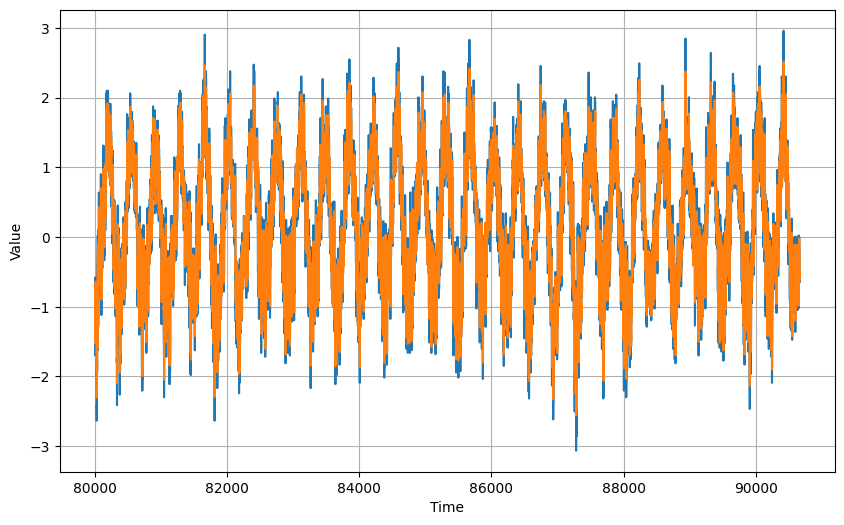

In [50]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

그래프 결과가 상당하 좋아 보인다.

데이터가 너무 많아 구분하기 어려우니 마지막 100일치만 확대해서 보겠다.

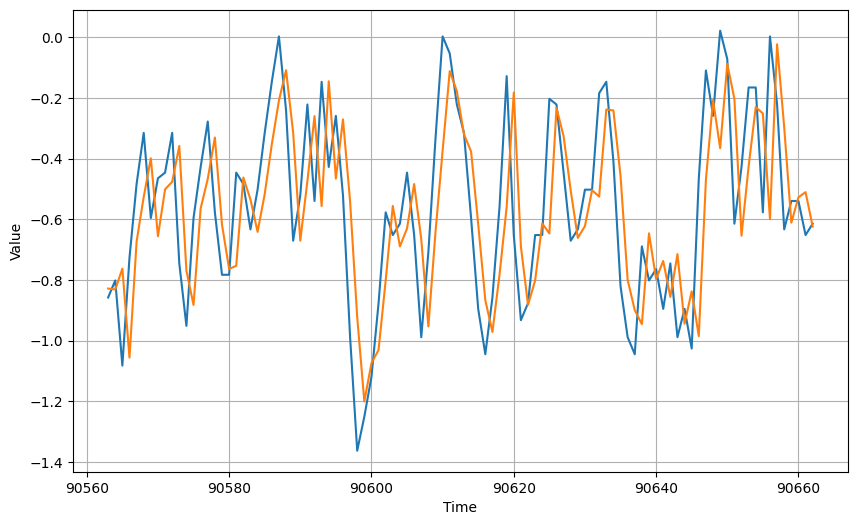

In [51]:
plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

예측 곡선이 대체적으로 데이터를 따라가고 트렌드를 정확하게 예측하고 있지만, 특히 양극단에서 상당히 간격이 벌어져 있으므로 개선할 여지가 있다.

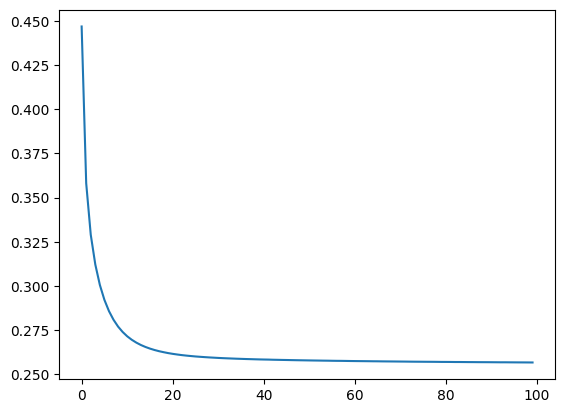

In [52]:
plt.plot(history.history['mae'])

데이터를 정규화 했기 떄문에 MAE가 낮아보인다. 오해를 일으킬 수 있다.

### 11.4. 다른 순환 층

SimpleRNN 이외에도 **GRU** 와 **LSTM** 같은 다른 종류의 순환 층을 제공한다.


이 장에서처럼 데이터를 TFRecord 기반으로 구성하면 이런 RNN 층을 바꾸어 실험하는 작업이 비교적 간단하다.

**GRU** 로 바꾸는 작업을 보겠다.


In [58]:
import tensorflow as tf
model = tf.keras.models.Seuquential([
    tf.keras.layers.GRU(100, input_shape=[None, 1],
                        return_sequences=True),
    tf.keras.layers.GRU(100),
    tf.keras.layers.Dense(1)
])

AttributeError: module 'keras.api._v2.keras.models' has no attribute 'Seuquential'

LSTM도 비슷하다

In [56]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=[None, 1],
                         return_sequences=True),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

AttributeError: module 'keras.api._v2.keras.models' has no attribute 'Seuquential'

### 11.5. 드롭아웃 사용하기

과대적합이 되었다면 드롭아웃을 사용할 수 있다. 드롭아웃은 훈련하는 동안 이웃한 뉴런을 랜덤하게 제외시킨다.

RNN에서는 순환 드롭아웃 매개변수도 제공한다.

**(RNN 드롭아웃에 대한 자세한 설명은 책 279p)**

https://arxiv.org/pdf/1512.05287.pdf 에서 수학적 관점으로 살펴본 순환드롭아웃의 작동 방식 자세히 확인 가능(야린 갈과 주빈 가라마니의 논문)

---
야린 갈은 딥러닝의 불확실성 연구에서 순환 드롭아웃을 사용할 때 고려해야할 한 가지 사항을 제시했다.

- 모든 타임 스텝에 동일 패턴의 드롭아웃이 적용되어야 하고 따라서 일정한 드롭아웃 마스크가 모든 타임 스텝에 적용되어야 한다는 것을 입증

- 일반적으로 드롭아웃은 랜덤하지만 tf.keras에서 제공하는 드롭아웃은 야린 갈의 연구에서 권장하는 방식을 따른다.

드롭아웃과 순환 드롭아웃을 추가하려면 층에 해당 매개변수를 지정하면 된다.

In [55]:
model = tf.keras.models.Sequential([ tf.keras.models.Sequential
    tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True,
                        dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1)
])

AttributeError: module 'keras.api._v2.keras.models' has no attribute 'Seuquential'

드롭아웃을 사용한 RNN은 종종 수렴에 더 오랜 시간이 걸린다. 따라서 더 많은 에폭 동안 훈련해야 한다.

데이터 너무 많으니까 오래 걸려서 이전 데이터 쓰겠다.

In [59]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [60]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [61]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size,
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size,
                                 batch_size, shuffle_buffer_size)

In [62]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True,
                        dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1,
                    validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 11s 79ms/step - loss: 0.4680 - mae: 0.8805 - val_loss: 0.5213 - val_mae: 0.9462
Epoch 2/500
64/64 [==============================] - 6s 87ms/step - loss: 0.4658 - mae: 0.8780 - val_loss: 0.5195 - val_mae: 0.9437
Epoch 3/500
64/64 [==============================] - 4s 70ms/step - loss: 0.4644 - mae: 0.8766 - val_loss: 0.5178 - val_mae: 0.9413
Epoch 4/500
64/64 [==============================] - 6s 93ms/step - loss: 0.4619 - mae: 0.8735 - val_loss: 0.5160 - val_mae: 0.9389
Epoch 5/500
64/64 [==============================] - 6s 88ms/step - loss: 0.4609 - mae: 0.8721 - val_loss: 0.5143 - val_mae: 0.9365
Epoch 6/500
64/64 [==============================] - 5s 80ms/step - loss: 0.4587 - mae: 0.8697 - val_loss: 0.5125 - val_mae: 0.9341
Epoch 7/500
64/64 [==============================] - 5s 82ms/step - loss: 0.4575 - mae: 0.8681 - val_loss: 0.5108 - val_mae: 0.9318
Epoch 8/500
64/64 [==============================] - 4s 68ms/step - loss: 0

In [63]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 48ms/step


In [64]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.33465782

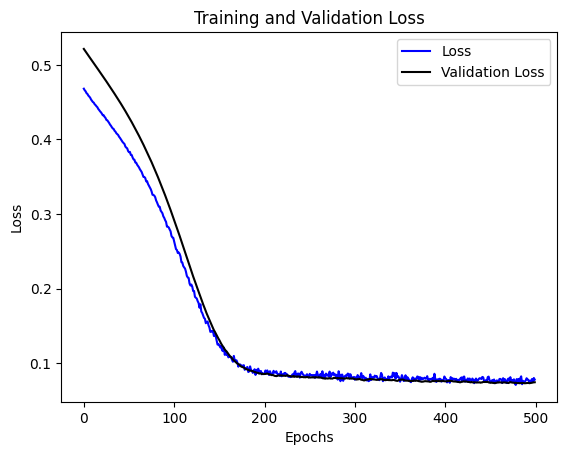

In [65]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

300번 에폭까지 손실과 MAE가 빠르게 감소. 그 이후에도 감소하긴 하지만 요동이 상당하 많다.

드롭아웃을 사용할 떄 이런 요동이 종종 관찰된다.

이는 학습률 같은 손실 함수의 파라미터는 물론 드롭아웃의 양을 조절할 수 있다는 의미이다.


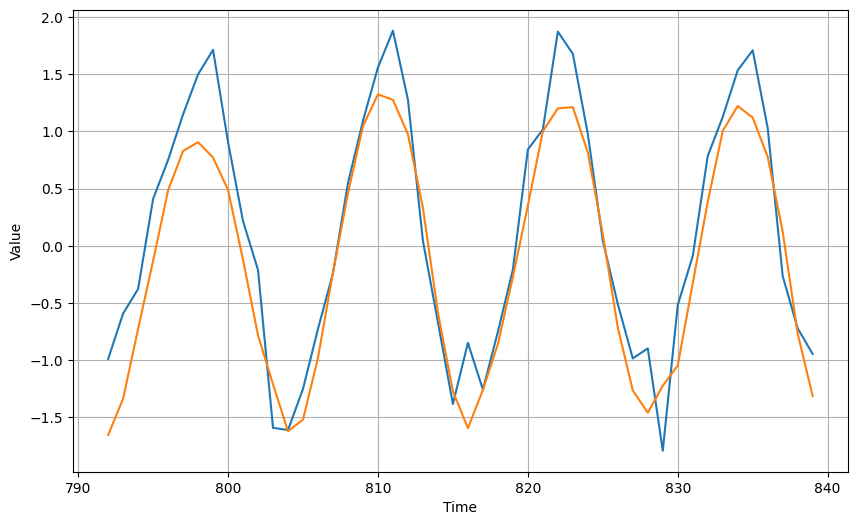

In [66]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

꽤 준수하지만 밑의 그래프에서 최고점을 보면 실제값보다 많이 낮아 개선될 여지가 있다.


케라스튜너 같은 도구로 하이퍼파라미터 튜닝하면 모델과 예측 결과 향상 가능

### 11.6. 양방향 RNN 사용하기

각 스텝에서 시퀀스의 원래 순서와, 역순으로 한 번씩 훈련한다.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True,
                        dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1,
                    validation_data=valid_dataset)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 27s 194ms/step - loss: 0.4487 - mae: 0.8586 - val_loss: 0.4970 - val_mae: 0.9178
Epoch 2/500
64/64 [==============================] - 11s 172ms/step - loss: 0.4386 - mae: 0.8467 - val_loss: 0.4851 - val_mae: 0.9045
Epoch 3/500
64/64 [==============================] - 11s 170ms/step - loss: 0.4281 - mae: 0.8342 - val_loss: 0.4732 - val_mae: 0.8915
Epoch 4/500
64/64 [==============================] - 11s 172ms/step - loss: 0.4195 - mae: 0.8236 - val_loss: 0.4617 - val_mae: 0.8788
Epoch 5/500
64/64 [==============================] - 11s 171ms/step - loss: 0.4088 - mae: 0.8115 - val_loss: 0.4505 - val_mae: 0.8664
Epoch 6/500
64/64 [==============================] - 11s 174ms/step - loss: 0.3997 - mae: 0.8002 - val_loss: 0.4393 - val_mae: 0.8538
Epoch 7/500
64/64 [==============================] - 11s 167ms/step - loss: 0.3878 - mae: 0.7863 - val_loss: 0.4282 - val_mae: 0.8413
Epoch 8/500
64/64 [==============================] - 11s 170ms

 tf.keras.layers.Bidirectional로 GRU층 감싸주면 된다.

In [ ]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

보이다 싶이 큰 차이는 없고 MAE도 비슷하다.

하지만 대규모 시계열 데이터셋에서는 정확도에 상당한 차이가 날 수 있으며,

여러 계절이 포함되도록 window_size 같은 훈련 파라미터를 조정하여 큰 영향을 끼칠 수 있다.